# Analysis nonA nucleotide use in poly(A) tails

In [9]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")

In [10]:
#Color palette for plots
four_palette = ["darkgreen", "tomato", "steelblue", "orange"]
two_palette = ["steelblue", "orange"]

In [11]:
figpath = "./"

Question: Is there an increased propensity to use nonA nt's in any of the PABPN1 mutants?

First read in the data

In [12]:
#Function to read polyA tab del files
def read_polyA_reads(file, min_read_count, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df = df.loc[df['tail_len'] >= min_read_count]
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [13]:
#path to the data
path = "path/to/data/"

In [14]:
#Read in dfs, assign to variables
min_A_count = 10

h112_1 = read_polyA_reads(path + 'results/polyA_len/h112.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path + 'results/polyA_len/h112.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path + 'results/polyA_len/h113.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path + 'results/polyA_len/h113.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path + 'results/polyA_len/h115.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path + 'results/polyA_len/h115.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path + 'results/polyA_len/h117.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path + 'results/polyA_len/h117.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path + "config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)
all_reads["gene_id"] = all_reads["gene_id"].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

Determine whether there is nonA usage in tails. First align the first or last 400 nt of poly(A) tails and calculate the percent of each nucleotide usage for each condition. 

In [ ]:
#Non A bases - run this cell once 
#trange defines the number of bases to consider in the tail alignment
trange = 400
from polyA_utils import *

total_c_h112_1, tail_len_h112_1, base_count_prox_h112_1, base_count_dist_h112_1, base_cov_h112_1 = nonA(path + 'results/mapping/h112.R1_hg38.bam', tail_range = trange)
total_c_h113_1, tail_len_h113_1, base_count_prox_h113_1, base_count_dist_h113_1, base_cov_h113_1 = nonA(path + 'results/mapping/h113.R1_hg38.bam', tail_range = trange)
total_c_h115_1, tail_len_h115_1, base_count_prox_h115_1, base_count_dist_h115_1, base_cov_h115_1 = nonA(path + 'results/mapping/h115.R1_hg38.bam', tail_range = trange)
total_c_h117_1, tail_len_h117_1, base_count_prox_h117_1, base_count_dist_h117_1, base_cov_h117_1 = nonA(path + 'results/mapping/h117.R1_hg38.bam', tail_range = trange)

total_c_h112_2, tail_len_h112_2, base_count_prox_h112_2, base_count_dist_h112_2, base_cov_h112_2 = nonA(path + 'results/mapping/h112.R2_hg38.bam', tail_range = trange)
total_c_h113_2, tail_len_h113_2, base_count_prox_h113_2, base_count_dist_h113_2, base_cov_h113_2 = nonA(path + 'results/mapping/h113.R2_hg38.bam', tail_range = trange)
total_c_h115_2, tail_len_h115_2, base_count_prox_h115_2, base_count_dist_h115_2, base_cov_h115_2 = nonA(path + 'results/mapping/h115.R2_hg38.bam', tail_range = trange)
total_c_h117_2, tail_len_h117_2, base_count_prox_h117_2, base_count_dist_h117_2, base_cov_h117_2 = nonA(path + 'results/mapping/h117.R2_hg38.bam', tail_range = trange)

Are there any differences in the percent of each base used between conditions?

In [9]:
nt_df = pd.concat([
    pd.DataFrame.from_dict(total_c_h112_1, orient = "index").transpose(),
    pd.DataFrame.from_dict(total_c_h112_2, orient = "index").transpose(),

    pd.DataFrame.from_dict(total_c_h113_1, orient = "index").transpose(),
    pd.DataFrame.from_dict(total_c_h113_2, orient = "index").transpose(),

    pd.DataFrame.from_dict(total_c_h115_1, orient = "index").transpose(),
    pd.DataFrame.from_dict(total_c_h115_2, orient = "index").transpose(),

    pd.DataFrame.from_dict(total_c_h117_1, orient = "index").transpose(),
    pd.DataFrame.from_dict(total_c_h117_2, orient = "index").transpose()
        ])

nt_df = nt_df.div(nt_df.sum(axis=1), axis=0)

nt_df["Sample"] = ["EV", "EV", "WT", "WT", "4SA", "4SA", "4SD", "4SD"]
nt_df["Replicate"] = [1, 2, 1, 2, 1, 2, 1, 2]

In [10]:
nt_df.head()

,A,G,C,T,Sample,Replicate
0,0.972166,0.009359,0.008103,0.010372,EV,1
0,0.985901,0.004331,0.004573,0.005196,EV,2
0,0.976301,0.007911,0.006978,0.008811,WT,1
0,0.986503,0.004079,0.004489,0.004929,WT,2
0,0.980071,0.006672,0.005826,0.007431,4SA,1


Text(0, 0.5, 'percent nt usage')

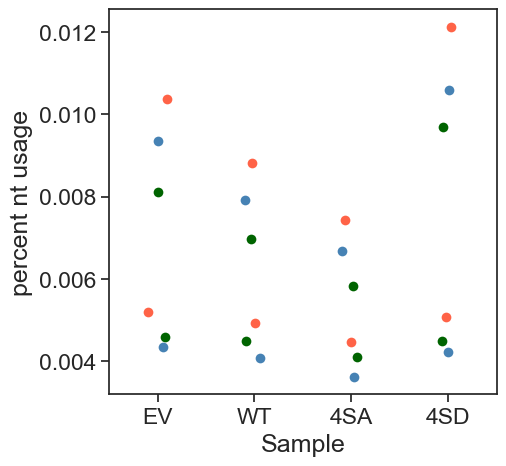

In [11]:
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.stripplot(x = nt_df["Sample"], y = nt_df["C"], color = "darkgreen", size = 7)
sns.stripplot(x = nt_df["Sample"], y = nt_df["G"], color = "steelblue", size = 7)
sns.stripplot(x = nt_df["Sample"], y = nt_df["T"], color = "tomato", size = 7)

ax.set_ylabel("percent nt usage")

First create a dataframe of the nonA nt usasge calculated above for ease of plot generation. Then generate plots to look at the percent of each nucleotide used across the alignments

In [12]:
#Function to create a dataframe from tail composition data
def nonA_df(total_c, tail_len, base_count_prox, base_count_dist, base_cov):
    #EV - 5' alignment
    x=np.arange(1, 401)
    percent_5 = pd.DataFrame()
    percent_5['A'] = base_count_prox[0]/base_cov
    percent_5['G'] = base_count_prox[1]/base_cov
    percent_5['U'] = base_count_prox[2]/base_cov
    percent_5['C'] = base_count_prox[3]/base_cov
    percent_5['reads'] = base_cov
    #EV - 3' alignment
    x=np.arange(1, 401)
    percent_3 = pd.DataFrame()
    percent_3['A'] = base_count_dist[0]/base_cov[::-1]
    percent_3['G'] = base_count_dist[1]/base_cov[::-1]
    percent_3['U'] = base_count_dist[2]/base_cov[::-1]
    percent_3['C'] = base_count_dist[3]/base_cov[::-1]
    percent_3['reads'] = base_cov[::-1]
    return(percent_5, percent_3)

Run the function on all conditions.

In [13]:
#EV
h112_1_df_5, h112_1_df_3 = nonA_df(total_c_h112_1, tail_len_h112_1, base_count_prox_h112_1, base_count_dist_h112_1, base_cov_h112_1)
h112_2_df_5, h112_2_df_3 = nonA_df(total_c_h112_2, tail_len_h112_2, base_count_prox_h112_2, base_count_dist_h112_2, base_cov_h112_2)
tmp = pd.concat((h112_1_df_5, h112_2_df_5))
h112_percent_5 = tmp.groupby(tmp.index).mean()
tmp = pd.concat((h112_1_df_3, h112_2_df_3))
h112_percent_3 = tmp.groupby(tmp.index).mean()
#WT
h113_1_df_5, h113_1_df_3 = nonA_df(total_c_h113_1, tail_len_h113_1, base_count_prox_h113_1, base_count_dist_h113_1, base_cov_h113_1)
h113_2_df_5, h113_2_df_3 = nonA_df(total_c_h113_2, tail_len_h113_2, base_count_prox_h113_2, base_count_dist_h113_2, base_cov_h113_2)
tmp = pd.concat((h113_1_df_5, h113_2_df_5))
h113_percent_5 = tmp.groupby(tmp.index).mean()
tmp = pd.concat((h113_1_df_3, h113_2_df_3))
h113_percent_3 = tmp.groupby(tmp.index).mean()
#4SA
h115_1_df_5, h115_1_df_3 = nonA_df(total_c_h115_1, tail_len_h115_1, base_count_prox_h115_1, base_count_dist_h115_1, base_cov_h115_1)
h115_2_df_5, h115_2_df_3 = nonA_df(total_c_h115_2, tail_len_h115_2, base_count_prox_h115_2, base_count_dist_h115_2, base_cov_h115_2)
tmp = pd.concat((h115_1_df_5, h115_2_df_5))
h115_percent_5 = tmp.groupby(tmp.index).mean()
tmp = pd.concat((h115_1_df_3, h115_2_df_3))
h115_percent_3 = tmp.groupby(tmp.index).mean()
#4SD
h117_1_df_5, h117_1_df_3 = nonA_df(total_c_h117_1, tail_len_h117_1, base_count_prox_h117_1, base_count_dist_h117_1, base_cov_h117_1)
h117_2_df_5, h117_2_df_3 = nonA_df(total_c_h117_2, tail_len_h117_2, base_count_prox_h117_2, base_count_dist_h117_2, base_cov_h117_2)
tmp = pd.concat((h117_1_df_5, h117_2_df_5))
h117_percent_5 = tmp.groupby(tmp.index).mean()
tmp = pd.concat((h117_1_df_3, h117_2_df_3))
h117_percent_3 = tmp.groupby(tmp.index).mean()

Now plot the percent use of each nucleotide for each condition

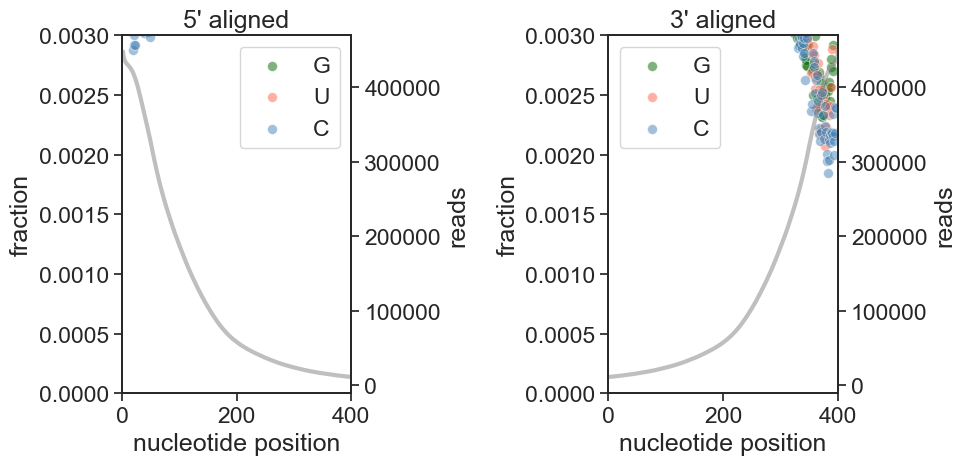

In [14]:
#Plot EV data - all reads
x = np.arange(1, 401)

fig, (ax1, ax3) = plt.subplots(1,2, figsize=(10,5))

ax1 = sns.scatterplot(data = h112_percent_5, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax1)
ax1 = sns.scatterplot(data = h112_percent_5, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax1)
ax1 = sns.scatterplot(data = h112_percent_5, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax1)
ax1.set_xlim([-1, 400])
ax1.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax1.set_ylabel('fraction')
ax1.legend(['G', 'U', 'C'])
ax1.set_title("5' aligned")
ax3.set_title("3' aligned")
#ax.set_title("S->D 5' tail")
ax2 = ax1.twinx()
ax2 = sns.lineplot(data = h112_percent_5, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)

ax3 = sns.scatterplot(data = h112_percent_3, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax3)
ax3 = sns.scatterplot(data = h112_percent_3, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax3)
ax3 = sns.scatterplot(data = h112_percent_3, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax3)
ax3.set_xlim([0, 400])
ax3.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax3.set_ylabel('fraction')
ax3.legend(['G', 'U', 'C'])
#ax.set_title("S->D 5' tail")
ax4 = ax3.twinx()
ax4 = sns.lineplot(data = h112_percent_3, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)
ax1.set_xlabel("nucleotide position")
ax3.set_xlabel("nucleotide position")

fig.tight_layout()

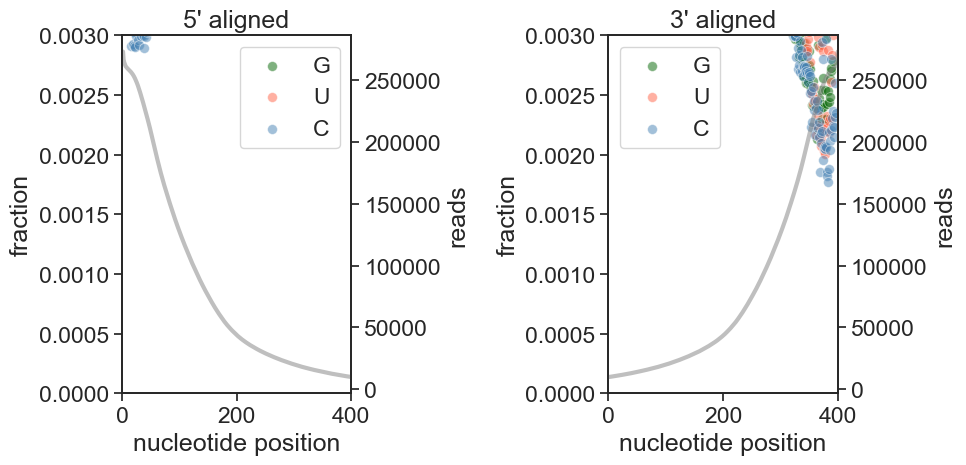

In [15]:
#Plot WT data - all reads
x = np.arange(1, 401)

fig, (ax1, ax3) = plt.subplots(1,2, figsize=(10,5))

ax1 = sns.scatterplot(data = h113_percent_5, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax1)
ax1 = sns.scatterplot(data = h113_percent_5, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax1)
ax1 = sns.scatterplot(data = h113_percent_5, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax1)
ax1.set_xlim([-1, 400])
ax1.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax1.set_ylabel('fraction')
ax1.legend(['G', 'U', 'C'])
ax1.set_title("5' aligned")
ax3.set_title("3' aligned")
#ax.set_title("S->D 5' tail")
ax2 = ax1.twinx()
ax2 = sns.lineplot(data = h113_percent_5, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)

ax3 = sns.scatterplot(data = h113_percent_3, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax3)
ax3 = sns.scatterplot(data = h113_percent_3, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax3)
ax3 = sns.scatterplot(data = h113_percent_3, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax3)
ax3.set_xlim([0, 400])
ax3.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax3.set_ylabel('fraction')
ax3.legend(['G', 'U', 'C'])
#ax.set_title("S->D 5' tail")
ax4 = ax3.twinx()
ax4 = sns.lineplot(data = h113_percent_3, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)
ax1.set_xlabel("nucleotide position")
ax3.set_xlabel("nucleotide position")

fig.tight_layout()

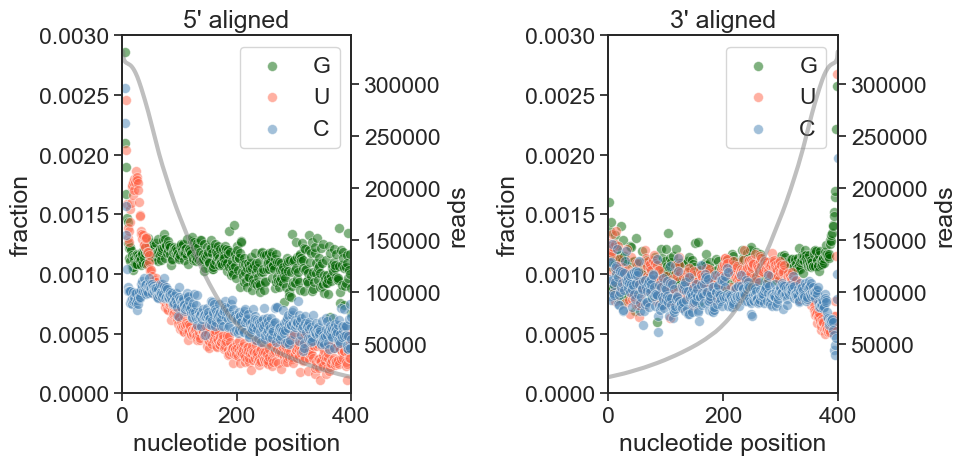

In [17]:
#Plot 4SA data - all reads
x = np.arange(1, 401)

fig, (ax1, ax3) = plt.subplots(1,2, figsize=(10,5))

ax1 = sns.scatterplot(data = h115_percent_5, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax1)
ax1 = sns.scatterplot(data = h115_percent_5, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax1)
ax1 = sns.scatterplot(data = h115_percent_5, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax1)
ax1.set_xlim([-1, 400])
ax1.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax1.set_ylabel('fraction')
ax1.legend(['G', 'U', 'C'])
ax1.set_title("5' aligned")
ax3.set_title("3' aligned")
#ax.set_title("S->D 5' tail")
ax2 = ax1.twinx()
ax2 = sns.lineplot(data = h115_percent_5, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)

ax3 = sns.scatterplot(data = h115_percent_3, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax3)
ax3 = sns.scatterplot(data = h115_percent_3, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax3)
ax3 = sns.scatterplot(data = h115_percent_3, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax3)
ax3.set_xlim([0, 400])
ax3.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax3.set_ylabel('fraction')
ax3.legend(['G', 'U', 'C'])
#ax.set_title("S->D 5' tail")
ax4 = ax3.twinx()
ax4 = sns.lineplot(data = h115_percent_3, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)
ax1.set_xlabel("nucleotide position")
ax3.set_xlabel("nucleotide position")

fig.tight_layout()

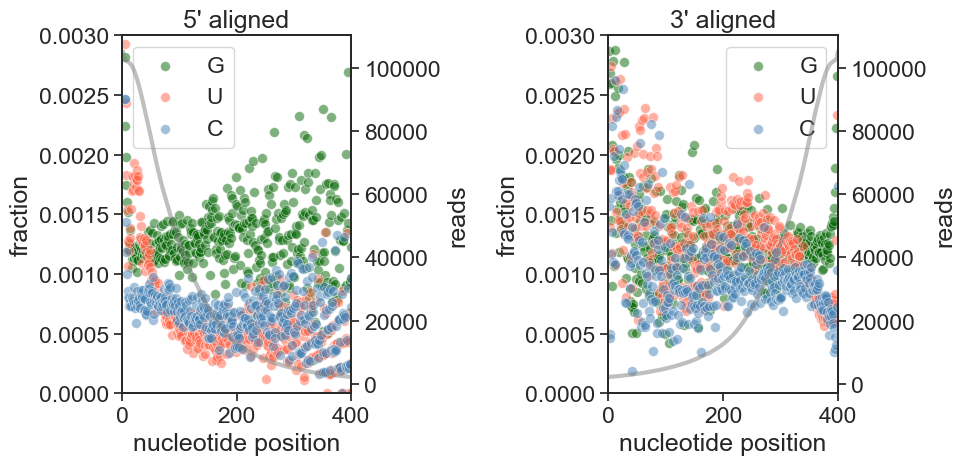

In [18]:
#Plot 4SD data - all reads
x = np.arange(1, 401)

fig, (ax1, ax3) = plt.subplots(1,2, figsize=(10,5))

ax1 = sns.scatterplot(data = h117_percent_5, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax1)
ax1 = sns.scatterplot(data = h117_percent_5, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax1)
ax1 = sns.scatterplot(data = h117_percent_5, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax1)
ax1.set_xlim([-1, 400])
ax1.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax1.set_ylabel('fraction')
ax1.legend(['G', 'U', 'C'])
ax1.set_title("5' aligned")
ax3.set_title("3' aligned")
#ax.set_title("S->D 5' tail")
ax2 = ax1.twinx()
ax2 = sns.lineplot(data = h117_percent_5, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)

ax3 = sns.scatterplot(data = h117_percent_3, x=x, y='G', alpha=.5, s = 50, color = 'darkgreen', ax = ax3)
ax3 = sns.scatterplot(data = h117_percent_3, x=x, y='U', alpha=.5, s = 50, color = 'tomato', ax = ax3)
ax3 = sns.scatterplot(data = h117_percent_3, x=x, y='C', alpha=.5, s = 50, color = 'steelblue', ax = ax3)
ax3.set_xlim([0, 400])
ax3.set_ylim([0, 0.003])
#ax1.set_yscale('log')
ax3.set_ylabel('fraction')
ax3.legend(['G', 'U', 'C'])
#ax.set_title("S->D 5' tail")
ax4 = ax3.twinx()
ax4 = sns.lineplot(data = h117_percent_3, x=x, y='reads', alpha=.5, color = 'grey', lw = 3)
ax1.set_xlabel("nucleotide position")
ax3.set_xlabel("nucleotide position")

fig.tight_layout()

The alignments will be noisly looking at position-to-position differences. Define a function to create bins in which to look at differences. 

In [20]:
def bin_array(mut, cov, binsize, **kwargs):
    # reactivity calculation in discrete bins of polymerase positions
    assert len(mut) == len(cov)

    bins = np.arange(0, len(mut), binsize)
    mut_bin = np.zeros(len(bins))
    cov_bin = np.zeros(len(bins))

    for i in range(len(bins)):
        if i < len(bins)-1:
            cov_bin[i] = np.sum(cov[bins[i]:bins[i+1]])
            mut_bin[i] = np.sum(mut[bins[i]:bins[i+1]])

        else: # last bin in case it doesn't add up
            cov_bin[i] = np.sum(cov[bins[i]:])
            mut_bin[i] = np.sum(mut[bins[i]:])
            
    return(bins, mut_bin, cov_bin)

In [21]:
#EV
bins = 5
base_count_prox_a_h112_1_bins = bin_array(base_count_prox_h112_1[0], base_cov_h112_1, bins)
base_count_prox_a_h112_2_bins = bin_array(base_count_prox_h112_2[0], base_cov_h112_2, bins)

base_count_prox_g_h112_1_bins = bin_array(base_count_prox_h112_1[1], base_cov_h112_1, bins)
base_count_prox_g_h112_2_bins = bin_array(base_count_prox_h112_2[1], base_cov_h112_2, bins)

base_count_prox_u_h112_1_bins = bin_array(base_count_prox_h112_1[2], base_cov_h112_1, bins)
base_count_prox_u_h112_2_bins = bin_array(base_count_prox_h112_2[2], base_cov_h112_2, bins)

base_count_prox_c_h112_1_bins = bin_array(base_count_prox_h112_1[3], base_cov_h112_1, bins)
base_count_prox_c_h112_2_bins = bin_array(base_count_prox_h112_2[3], base_cov_h112_2, bins)

base_count_dist_a_h112_1_bins = bin_array(base_count_dist_h112_1[0], base_cov_h112_1, bins)
base_count_dist_a_h112_2_bins = bin_array(base_count_dist_h112_2[0], base_cov_h112_2, bins)

base_count_dist_g_h112_1_bins = bin_array(base_count_dist_h112_1[1], base_cov_h112_1, bins)
base_count_dist_g_h112_2_bins = bin_array(base_count_dist_h112_2[1], base_cov_h112_2, bins)

base_count_dist_u_h112_1_bins = bin_array(base_count_dist_h112_1[2], base_cov_h112_1, bins)
base_count_dist_u_h112_2_bins = bin_array(base_count_dist_h112_2[2], base_cov_h112_2, bins)

base_count_dist_c_h112_1_bins = bin_array(base_count_dist_h112_1[3], base_cov_h112_1, bins)
base_count_dist_c_h112_2_bins = bin_array(base_count_dist_h112_2[3], base_cov_h112_2, bins)

In [22]:
#WT
bins = 5
base_count_prox_a_h113_1_bins = bin_array(base_count_prox_h113_1[0], base_cov_h113_1, bins)
base_count_prox_a_h113_2_bins = bin_array(base_count_prox_h113_2[0], base_cov_h113_2, bins)

base_count_prox_g_h113_1_bins = bin_array(base_count_prox_h113_1[1], base_cov_h113_1, bins)
base_count_prox_g_h113_2_bins = bin_array(base_count_prox_h113_2[1], base_cov_h113_2, bins)

base_count_prox_u_h113_1_bins = bin_array(base_count_prox_h113_1[2], base_cov_h113_1, bins)
base_count_prox_u_h113_2_bins = bin_array(base_count_prox_h113_2[2], base_cov_h113_2, bins)

base_count_prox_c_h113_1_bins = bin_array(base_count_prox_h113_1[3], base_cov_h113_1, bins)
base_count_prox_c_h113_2_bins = bin_array(base_count_prox_h113_2[3], base_cov_h113_2, bins)

base_count_dist_a_h113_1_bins = bin_array(base_count_dist_h113_1[0], base_cov_h113_1, bins)
base_count_dist_a_h113_2_bins = bin_array(base_count_dist_h113_2[0], base_cov_h113_2, bins)

base_count_dist_g_h113_1_bins = bin_array(base_count_dist_h113_1[1], base_cov_h113_1, bins)
base_count_dist_g_h113_2_bins = bin_array(base_count_dist_h113_2[1], base_cov_h113_2, bins)

base_count_dist_u_h113_1_bins = bin_array(base_count_dist_h113_1[2], base_cov_h113_1, bins)
base_count_dist_u_h113_2_bins = bin_array(base_count_dist_h113_2[2], base_cov_h113_2, bins)

base_count_dist_c_h113_1_bins = bin_array(base_count_dist_h113_1[3], base_cov_h113_1, bins)
base_count_dist_c_h113_2_bins = bin_array(base_count_dist_h113_2[3], base_cov_h113_2, bins)


In [23]:
#4SA
bins = 5
base_count_prox_a_h115_1_bins = bin_array(base_count_prox_h115_1[0], base_cov_h115_1, bins)
base_count_prox_a_h115_2_bins = bin_array(base_count_prox_h115_2[0], base_cov_h115_2, bins)

base_count_prox_g_h115_1_bins = bin_array(base_count_prox_h115_1[1], base_cov_h115_1, bins)
base_count_prox_g_h115_2_bins = bin_array(base_count_prox_h115_2[1], base_cov_h115_2, bins)

base_count_prox_u_h115_1_bins = bin_array(base_count_prox_h115_1[2], base_cov_h115_1, bins)
base_count_prox_u_h115_2_bins = bin_array(base_count_prox_h115_2[2], base_cov_h115_2, bins)

base_count_prox_c_h115_1_bins = bin_array(base_count_prox_h115_1[3], base_cov_h115_1, bins)
base_count_prox_c_h115_2_bins = bin_array(base_count_prox_h115_2[3], base_cov_h115_2, bins)

base_count_dist_a_h115_1_bins = bin_array(base_count_dist_h115_1[0], base_cov_h115_1, bins)
base_count_dist_a_h115_2_bins = bin_array(base_count_dist_h115_2[0], base_cov_h115_2, bins)

base_count_dist_g_h115_1_bins = bin_array(base_count_dist_h115_1[1], base_cov_h115_1, bins)
base_count_dist_g_h115_2_bins = bin_array(base_count_dist_h115_2[1], base_cov_h115_2, bins)

base_count_dist_u_h115_1_bins = bin_array(base_count_dist_h115_1[2], base_cov_h115_1, bins)
base_count_dist_u_h115_2_bins = bin_array(base_count_dist_h115_2[2], base_cov_h115_2, bins)

base_count_dist_c_h115_1_bins = bin_array(base_count_dist_h115_1[3], base_cov_h115_1, bins)
base_count_dist_c_h115_2_bins = bin_array(base_count_dist_h115_2[3], base_cov_h115_2, bins)


In [24]:
#4SD
bins = 5
base_count_prox_a_h117_1_bins = bin_array(base_count_prox_h117_1[0], base_cov_h117_1, bins)
base_count_prox_a_h117_2_bins = bin_array(base_count_prox_h117_2[0], base_cov_h117_2, bins)

base_count_prox_g_h117_1_bins = bin_array(base_count_prox_h117_1[1], base_cov_h117_1, bins)
base_count_prox_g_h117_2_bins = bin_array(base_count_prox_h117_2[1], base_cov_h117_2, bins)

base_count_prox_u_h117_1_bins = bin_array(base_count_prox_h117_1[2], base_cov_h117_1, bins)
base_count_prox_u_h117_2_bins = bin_array(base_count_prox_h117_2[2], base_cov_h117_2, bins)

base_count_prox_c_h117_1_bins = bin_array(base_count_prox_h117_1[3], base_cov_h117_1, bins)
base_count_prox_c_h117_2_bins = bin_array(base_count_prox_h117_2[3], base_cov_h117_2, bins)

base_count_dist_a_h117_1_bins = bin_array(base_count_dist_h117_1[0], base_cov_h117_1, bins)
base_count_dist_a_h117_2_bins = bin_array(base_count_dist_h117_2[0], base_cov_h117_2, bins)

base_count_dist_g_h117_1_bins = bin_array(base_count_dist_h117_1[1], base_cov_h117_1, bins)
base_count_dist_g_h117_2_bins = bin_array(base_count_dist_h117_2[1], base_cov_h117_2, bins)

base_count_dist_u_h117_1_bins = bin_array(base_count_dist_h117_1[2], base_cov_h117_1, bins)
base_count_dist_u_h117_2_bins = bin_array(base_count_dist_h117_2[2], base_cov_h117_2, bins)

base_count_dist_c_h117_1_bins = bin_array(base_count_dist_h117_1[3], base_cov_h117_1, bins)
base_count_dist_c_h117_2_bins = bin_array(base_count_dist_h117_2[3], base_cov_h117_2, bins)


In [25]:
(base_count_dist_u_h115_1_bins[1]/(base_count_dist_u_h115_1_bins[2] + base_count_dist_u_h115_1_bins[1]) + 
base_count_dist_u_h115_2_bins[1]/(base_count_dist_u_h115_2_bins[2] + base_count_dist_u_h115_2_bins[1]))/2

array([0.00087601, 0.00092931, 0.0009522 , 0.0009461 , 0.0010033 ,
       0.00099217, 0.00107045, 0.00108852, 0.00115952, 0.00122526,
       0.00125958, 0.00134177, 0.00145933, 0.001505  , 0.00166564,
       0.00171735, 0.00177514, 0.00191306, 0.00201743, 0.0021617 ,
       0.00219385, 0.00231663, 0.00246884, 0.00265417, 0.00285504,
       0.0028833 , 0.0031658 , 0.00339635, 0.0036146 , 0.00376031,
       0.00403312, 0.0041729 , 0.00454557, 0.00488297, 0.00519529,
       0.0057326 , 0.0059394 , 0.00630868, 0.00647857, 0.00695201,
       0.00750693, 0.00797154, 0.00778428, 0.00846894, 0.00871507,
       0.00889297, 0.00970708, 0.01001363, 0.01047413, 0.01088736,
       0.01108934, 0.01147929, 0.0122313 , 0.01323099, 0.01360972,
       0.01363487, 0.01469041, 0.01538614, 0.01573619, 0.01641672,
       0.01718671, 0.01769435, 0.01849972, 0.01953167, 0.02008446,
       0.01975986, 0.02093218, 0.02205209, 0.0227801 , 0.02441376,
       0.02481984, 0.0260031 , 0.02483347, 0.02536992, 0.02847

#### Generate figures to compare nonA use between two conditions

C usage - stats comparing 4SA to 4SD

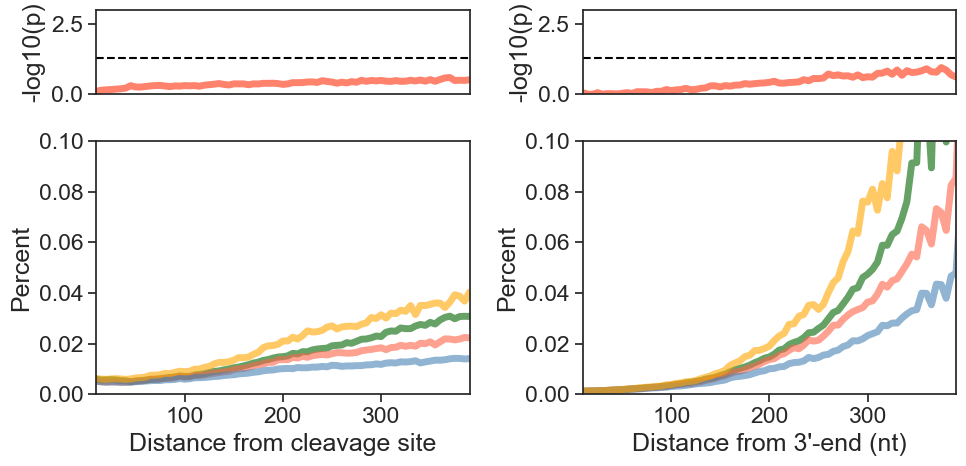

In [26]:
#Run t-test between percent nt ussage at each postion
stat_vals_5 = stats.ttest_ind(
                            [base_count_dist_c_h115_1_bins[1]/(base_count_dist_c_h115_1_bins[2] + base_count_dist_c_h115_1_bins[1]), base_count_dist_c_h115_2_bins[1]/(base_count_dist_c_h115_2_bins[2] + base_count_dist_c_h115_2_bins[1])],
                            [base_count_dist_c_h117_1_bins[1]/(base_count_dist_c_h117_1_bins[2] + base_count_dist_c_h117_1_bins[1]), base_count_dist_c_h117_2_bins[1]/(base_count_dist_c_h117_2_bins[2] + (base_count_dist_c_h117_2_bins[1]))])[-1]

#calculate FRD
stat_vals_corr_5 = stats.false_discovery_control(stat_vals_5)

#Run t-test between percent nt ussage at each postion
stat_vals_3 = stats.ttest_ind(
                            [base_count_prox_c_h115_1_bins[1]/(base_count_prox_c_h115_1_bins[2] + base_count_prox_c_h115_1_bins[1]), base_count_prox_c_h115_2_bins[1]/(base_count_prox_c_h115_2_bins[2] + base_count_prox_c_h115_2_bins[1])],
                            [base_count_prox_c_h117_1_bins[1]/(base_count_prox_c_h117_1_bins[2] + base_count_prox_c_h117_1_bins[1]), base_count_prox_c_h117_2_bins[1]/(base_count_prox_c_h117_2_bins[2] + (base_count_prox_c_h117_2_bins[1]))])[-1]

#calculate FRD
stat_vals_corr_3 = stats.false_discovery_control(stat_vals_3)

#############################################################

#Figure for percent nt - 5' end A
#Generate plot
fig, (ax2, axs) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 5))

#distal
sns.lineplot(x = (base_count_dist_c_h112_1_bins[0] + base_count_dist_c_h112_2_bins[0])/2, 
             y=(base_count_dist_c_h112_1_bins[1]/(base_count_dist_c_h112_1_bins[2] + base_count_dist_c_h112_1_bins[1])) + 
               (base_count_dist_c_h112_2_bins[1]/(base_count_dist_c_h112_2_bins[2] + base_count_dist_c_h112_2_bins[1]))/2, 
                alpha=.6, color = 'darkgreen', ax = axs[1], linewidth = 5)


sns.lineplot(x = (base_count_dist_c_h113_1_bins[0] + base_count_dist_c_h113_2_bins[0])/2, 
             y=(base_count_dist_c_h113_1_bins[1]/(base_count_dist_c_h113_1_bins[2] + base_count_dist_c_h113_1_bins[1])) + 
               (base_count_dist_c_h113_2_bins[1]/(base_count_dist_c_h113_2_bins[2] + base_count_dist_c_h113_2_bins[1]))/2, 
                alpha=.6, color = 'tomato', ax = axs[1], linewidth = 5)

sns.lineplot(x = (base_count_dist_c_h115_1_bins[0] + base_count_dist_c_h115_2_bins[0])/2, 
             y=(base_count_dist_c_h115_1_bins[1]/(base_count_dist_c_h115_1_bins[2] + base_count_dist_c_h115_1_bins[1])) + 
               (base_count_dist_c_h115_2_bins[1]/(base_count_dist_c_h115_2_bins[2] + base_count_dist_c_h115_2_bins[1]))/2, 
                alpha=.6, color = 'steelblue', ax = axs[1], linewidth = 5)

sns.lineplot(x = (base_count_dist_c_h117_1_bins[0] + base_count_dist_c_h117_2_bins[0])/2, 
             y=(base_count_dist_c_h117_1_bins[1]/(base_count_dist_c_h117_1_bins[2] + base_count_dist_c_h117_1_bins[1])) + 
               (base_count_dist_c_h117_2_bins[1]/(base_count_dist_c_h117_2_bins[2] + base_count_dist_c_h117_2_bins[1]))/2, 
                alpha=.6, color = 'orange', ax = axs[1], linewidth = 5)


ax2[1] = sns.lineplot(x = (base_count_dist_c_h115_1_bins[0] + base_count_dist_c_h115_2_bins[0])/2, 
                   y = -np.log10(stat_vals_5), 
                   alpha=.8, color = 'tomato', ax = ax2[1], linewidth = 5)

ax2[1].set_ylabel("-log10(p)")
ax2[1].axhline(-np.log10(0.05), linestyle = '--', color = 'black')

axs[1].set_xlim(10, 390)
ax2[1].set_xlim(10, 390)
ax2[1].set(xticklabels=[])  # remove the tick labels
ax2[1].tick_params(bottom=False)  # remove the ticks

axs[1].set_ylim(0, 0.1)
ax2[1].set_ylim(0,3)

axs[1].set_ylabel("Percent")
axs[1].set_xlabel("Distance from 3'-end (nt)")

###############################################
#proximal
sns.lineplot(x = (base_count_prox_c_h112_1_bins[0] + base_count_prox_c_h112_2_bins[0])/2, 
             y=(base_count_prox_c_h112_1_bins[1]/(base_count_prox_c_h112_1_bins[2] + base_count_prox_c_h112_1_bins[1])) + 
               (base_count_prox_c_h112_2_bins[1]/(base_count_prox_c_h112_2_bins[2] + base_count_prox_c_h112_2_bins[1]))/2, 
                alpha=.6, color = 'darkgreen', ax = axs[0], linewidth = 5)


sns.lineplot(x = (base_count_prox_c_h113_1_bins[0] + base_count_prox_c_h113_2_bins[0])/2, 
             y=(base_count_prox_c_h113_1_bins[1]/(base_count_prox_c_h113_1_bins[2] + base_count_prox_c_h113_1_bins[1])) + 
               (base_count_prox_c_h113_2_bins[1]/(base_count_prox_c_h113_2_bins[2] + base_count_prox_c_h113_2_bins[1]))/2, 
                alpha=.6, color = 'tomato', ax = axs[0], linewidth = 5)

sns.lineplot(x = (base_count_prox_c_h115_1_bins[0] + base_count_prox_c_h115_2_bins[0])/2, 
             y=(base_count_prox_c_h115_1_bins[1]/(base_count_prox_c_h115_1_bins[2] + base_count_prox_c_h115_1_bins[1])) + 
               (base_count_prox_c_h115_2_bins[1]/(base_count_prox_c_h115_2_bins[2] + base_count_prox_c_h115_2_bins[1]))/2, 
                alpha=.6, color = 'steelblue', ax = axs[0], linewidth = 5)

sns.lineplot(x = (base_count_prox_c_h117_1_bins[0] + base_count_prox_c_h117_2_bins[0])/2, 
             y=(base_count_prox_c_h117_1_bins[1]/(base_count_prox_c_h117_1_bins[2] + base_count_prox_c_h117_1_bins[1])) + 
               (base_count_prox_c_h117_2_bins[1]/(base_count_prox_c_h117_2_bins[2] + base_count_prox_c_h117_2_bins[1]))/2, 
                alpha=.6, color = 'orange', ax = axs[0], linewidth = 5)


ax2[0] = sns.lineplot(x = (base_count_prox_c_h115_1_bins[0] + base_count_prox_c_h115_2_bins[0])/2, 
                   y = -np.log10(stat_vals_3), 
                   alpha=.8, color = 'tomato', ax = ax2[0], linewidth = 5)

ax2[0].set_ylabel("-log10(p)")
ax2[0].axhline(-np.log10(0.05), linestyle = '--', color = 'black')

axs[0].set_xlim(10, 390)
ax2[0].set_xlim(10, 390)
ax2[0].set(xticklabels=[])  # remove the tick labels
ax2[0].tick_params(bottom=False)  # remove the ticks

axs[0].set_ylim(0, 0.1)
ax2[0].set_ylim(0,3)

axs[0].set_ylabel("Percent")
axs[0].set_xlabel("Distance from cleavage site")

fig.tight_layout()

# plt.savefig(figpath + 'nonA_C.png', dpi=300, bbox_inches="tight")

Compare G usage - stats for 4SA vs 4SD

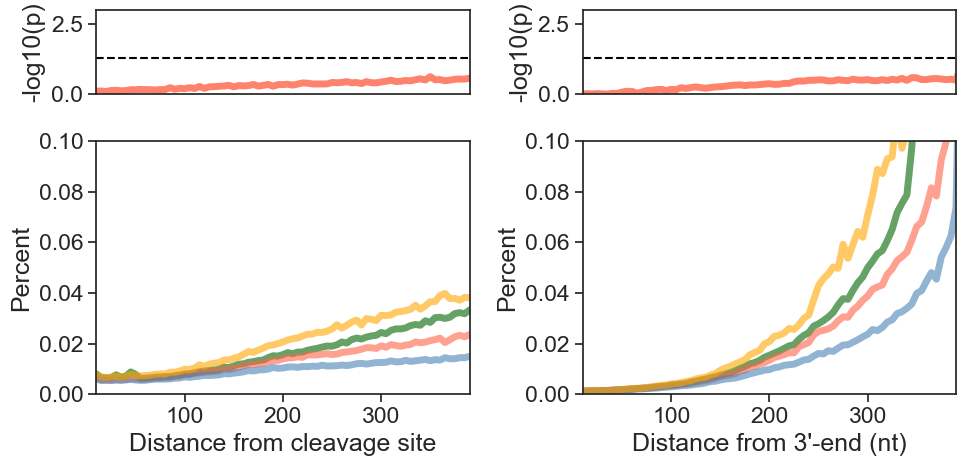

In [27]:
#Run t-test between percent nt ussage at each postion
stat_vals_5 = stats.ttest_ind(
                            [base_count_dist_g_h115_1_bins[1]/(base_count_dist_g_h115_1_bins[2] + base_count_dist_g_h115_1_bins[1]), base_count_dist_g_h115_2_bins[1]/(base_count_dist_g_h115_2_bins[2] + base_count_dist_g_h115_2_bins[1])],
                            [base_count_dist_g_h117_1_bins[1]/(base_count_dist_g_h117_1_bins[2] + base_count_dist_g_h117_1_bins[1]), base_count_dist_g_h117_2_bins[1]/(base_count_dist_g_h117_2_bins[2] + (base_count_dist_g_h117_2_bins[1]))])[-1]

#calculate FRD
stat_vals_corr_5 = stats.false_discovery_control(stat_vals_5)

#Run t-test between percent nt ussage at each postion
stat_vals_3 = stats.ttest_ind(
                            [base_count_prox_g_h115_1_bins[1]/(base_count_prox_g_h115_1_bins[2] + base_count_prox_g_h115_1_bins[1]), base_count_prox_g_h115_2_bins[1]/(base_count_prox_g_h115_2_bins[2] + base_count_prox_g_h115_2_bins[1])],
                            [base_count_prox_g_h117_1_bins[1]/(base_count_prox_g_h117_1_bins[2] + base_count_prox_g_h117_1_bins[1]), base_count_prox_g_h117_2_bins[1]/(base_count_prox_g_h117_2_bins[2] + (base_count_prox_g_h117_2_bins[1]))])[-1]

#calculate FRD
stat_vals_corr_3 = stats.false_discovery_control(stat_vals_3)

#############################################################

#Figure for percent nt - 5' end A
#Generate plot
fig, (ax2, axs) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 5))

#distal
sns.lineplot(x = (base_count_dist_g_h112_1_bins[0] + base_count_dist_g_h112_2_bins[0])/2, 
             y=(base_count_dist_g_h112_1_bins[1]/(base_count_dist_g_h112_1_bins[2] + base_count_dist_g_h112_1_bins[1])) + 
               (base_count_dist_g_h112_2_bins[1]/(base_count_dist_g_h112_2_bins[2] + base_count_dist_g_h112_2_bins[1]))/2, 
                alpha=.6, color = 'darkgreen', ax = axs[1], linewidth = 5)


sns.lineplot(x = (base_count_dist_g_h113_1_bins[0] + base_count_dist_g_h113_2_bins[0])/2, 
             y=(base_count_dist_g_h113_1_bins[1]/(base_count_dist_g_h113_1_bins[2] + base_count_dist_g_h113_1_bins[1])) + 
               (base_count_dist_g_h113_2_bins[1]/(base_count_dist_g_h113_2_bins[2] + base_count_dist_g_h113_2_bins[1]))/2, 
                alpha=.6, color = 'tomato', ax = axs[1], linewidth = 5)

sns.lineplot(x = (base_count_dist_g_h115_1_bins[0] + base_count_dist_g_h115_2_bins[0])/2, 
             y=(base_count_dist_g_h115_1_bins[1]/(base_count_dist_g_h115_1_bins[2] + base_count_dist_g_h115_1_bins[1])) + 
               (base_count_dist_g_h115_2_bins[1]/(base_count_dist_g_h115_2_bins[2] + base_count_dist_g_h115_2_bins[1]))/2, 
                alpha=.6, color = 'steelblue', ax = axs[1], linewidth = 5)

sns.lineplot(x = (base_count_dist_g_h117_1_bins[0] + base_count_dist_g_h117_2_bins[0])/2, 
             y=(base_count_dist_g_h117_1_bins[1]/(base_count_dist_g_h117_1_bins[2] + base_count_dist_g_h117_1_bins[1])) + 
               (base_count_dist_g_h117_2_bins[1]/(base_count_dist_g_h117_2_bins[2] + base_count_dist_g_h117_2_bins[1]))/2, 
                alpha=.6, color = 'orange', ax = axs[1], linewidth = 5)


ax2[1] = sns.lineplot(x = (base_count_dist_g_h115_1_bins[0] + base_count_dist_g_h115_2_bins[0])/2, 
                   y = -np.log10(stat_vals_5), 
                   alpha=.8, color = 'tomato', ax = ax2[1], linewidth = 5)

ax2[1].set_ylabel("-log10(p)")
ax2[1].axhline(-np.log10(0.05), linestyle = '--', color = 'black')

axs[1].set_xlim(10, 390)
ax2[1].set_xlim(10, 390)
ax2[1].set(xticklabels=[])  # remove the tick labels
ax2[1].tick_params(bottom=False)  # remove the ticks

axs[1].set_ylim(0, 0.1)
ax2[1].set_ylim(0,3)

axs[1].set_ylabel("Percent")
axs[1].set_xlabel("Distance from 3'-end (nt)")

###############################################
#proximal
sns.lineplot(x = (base_count_prox_g_h112_1_bins[0] + base_count_prox_g_h112_2_bins[0])/2, 
             y=(base_count_prox_g_h112_1_bins[1]/(base_count_prox_g_h112_1_bins[2] + base_count_prox_g_h112_1_bins[1])) + 
               (base_count_prox_g_h112_2_bins[1]/(base_count_prox_g_h112_2_bins[2] + base_count_prox_g_h112_2_bins[1]))/2, 
                alpha=.6, color = 'darkgreen', ax = axs[0], linewidth = 5)


sns.lineplot(x = (base_count_prox_g_h113_1_bins[0] + base_count_prox_g_h113_2_bins[0])/2, 
             y=(base_count_prox_g_h113_1_bins[1]/(base_count_prox_g_h113_1_bins[2] + base_count_prox_g_h113_1_bins[1])) + 
               (base_count_prox_g_h113_2_bins[1]/(base_count_prox_g_h113_2_bins[2] + base_count_prox_g_h113_2_bins[1]))/2, 
                alpha=.6, color = 'tomato', ax = axs[0], linewidth = 5)

sns.lineplot(x = (base_count_prox_g_h115_1_bins[0] + base_count_prox_g_h115_2_bins[0])/2, 
             y=(base_count_prox_g_h115_1_bins[1]/(base_count_prox_g_h115_1_bins[2] + base_count_prox_g_h115_1_bins[1])) + 
               (base_count_prox_g_h115_2_bins[1]/(base_count_prox_g_h115_2_bins[2] + base_count_prox_g_h115_2_bins[1]))/2, 
                alpha=.6, color = 'steelblue', ax = axs[0], linewidth = 5)

sns.lineplot(x = (base_count_prox_g_h117_1_bins[0] + base_count_prox_g_h117_2_bins[0])/2, 
             y=(base_count_prox_g_h117_1_bins[1]/(base_count_prox_g_h117_1_bins[2] + base_count_prox_g_h117_1_bins[1])) + 
               (base_count_prox_g_h117_2_bins[1]/(base_count_prox_g_h117_2_bins[2] + base_count_prox_g_h117_2_bins[1]))/2, 
                alpha=.6, color = 'orange', ax = axs[0], linewidth = 5)


ax2[0] = sns.lineplot(x = (base_count_prox_g_h115_1_bins[0] + base_count_prox_g_h115_2_bins[0])/2, 
                   y = -np.log10(stat_vals_3), 
                   alpha=.8, color = 'tomato', ax = ax2[0], linewidth = 5)

ax2[0].set_ylabel("-log10(p)")
ax2[0].axhline(-np.log10(0.05), linestyle = '--', color = 'black')

axs[0].set_xlim(10, 390)
ax2[0].set_xlim(10, 390)
ax2[0].set(xticklabels=[])  # remove the tick labels
ax2[0].tick_params(bottom=False)  # remove the ticks

axs[0].set_ylim(0, 0.1)
ax2[0].set_ylim(0,3)

axs[0].set_ylabel("Percent")
axs[0].set_xlabel("Distance from cleavage site")


fig.tight_layout()

# plt.savefig(figpath + 'NonA_G.png', dpi=300, bbox_inches="tight")

Compare U usage - stats for 4SA vs 4SD

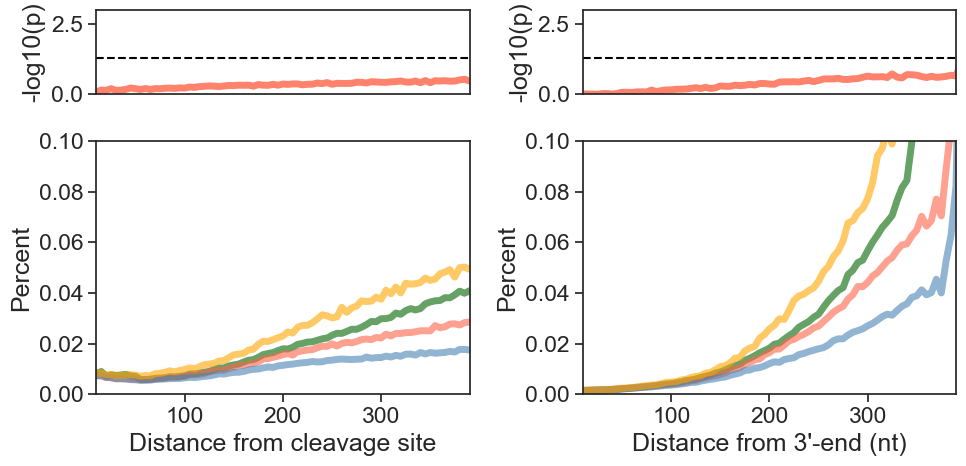

In [28]:
#Run t-test between percent nt ussage at each postion
stat_vals_5 = stats.ttest_ind(
                            [base_count_dist_u_h115_1_bins[1]/(base_count_dist_u_h115_1_bins[2] + base_count_dist_u_h115_1_bins[1]), base_count_dist_u_h115_2_bins[1]/(base_count_dist_u_h115_2_bins[2] + base_count_dist_u_h115_2_bins[1])],
                            [base_count_dist_u_h117_1_bins[1]/(base_count_dist_u_h117_1_bins[2] + base_count_dist_u_h117_1_bins[1]), base_count_dist_u_h117_2_bins[1]/(base_count_dist_u_h117_2_bins[2] + (base_count_dist_u_h117_2_bins[1]))])[-1]

#calculate FRD
stat_vals_corr_5 = stats.false_discovery_control(stat_vals_5)

#Run t-test between percent nt ussage at each postion
stat_vals_3 = stats.ttest_ind(
                            [base_count_prox_u_h115_1_bins[1]/(base_count_prox_u_h115_1_bins[2] + base_count_prox_u_h115_1_bins[1]), base_count_prox_u_h115_2_bins[1]/(base_count_prox_u_h115_2_bins[2] + base_count_prox_u_h115_2_bins[1])],
                            [base_count_prox_u_h117_1_bins[1]/(base_count_prox_u_h117_1_bins[2] + base_count_prox_u_h117_1_bins[1]), base_count_prox_u_h117_2_bins[1]/(base_count_prox_u_h117_2_bins[2] + (base_count_prox_u_h117_2_bins[1]))])[-1]

#calculate FRD
stat_vals_corr_3 = stats.false_discovery_control(stat_vals_3)

#############################################################

#Figure for percent nt - 5' end A
#Generate plot
fig, (ax2, axs) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 3]}, figsize=(10, 5))

#distal
sns.lineplot(x = (base_count_dist_u_h112_1_bins[0] + base_count_dist_u_h112_2_bins[0])/2, 
             y=(base_count_dist_u_h112_1_bins[1]/(base_count_dist_u_h112_1_bins[2] + base_count_dist_u_h112_1_bins[1])) + 
               (base_count_dist_u_h112_2_bins[1]/(base_count_dist_u_h112_2_bins[2] + base_count_dist_u_h112_2_bins[1]))/2, 
                alpha=.6, color = 'darkgreen', ax = axs[1], linewidth = 5)


sns.lineplot(x = (base_count_dist_u_h113_1_bins[0] + base_count_dist_u_h113_2_bins[0])/2, 
             y=(base_count_dist_u_h113_1_bins[1]/(base_count_dist_u_h113_1_bins[2] + base_count_dist_u_h113_1_bins[1])) + 
               (base_count_dist_u_h113_2_bins[1]/(base_count_dist_u_h113_2_bins[2] + base_count_dist_u_h113_2_bins[1]))/2, 
                alpha=.6, color = 'tomato', ax = axs[1], linewidth = 5)

sns.lineplot(x = (base_count_dist_u_h115_1_bins[0] + base_count_dist_u_h115_2_bins[0])/2, 
             y=(base_count_dist_u_h115_1_bins[1]/(base_count_dist_u_h115_1_bins[2] + base_count_dist_u_h115_1_bins[1])) + 
               (base_count_dist_u_h115_2_bins[1]/(base_count_dist_u_h115_2_bins[2] + base_count_dist_u_h115_2_bins[1]))/2, 
                alpha=.6, color = 'steelblue', ax = axs[1], linewidth = 5)

sns.lineplot(x = (base_count_dist_u_h117_1_bins[0] + base_count_dist_u_h117_2_bins[0])/2, 
             y=(base_count_dist_u_h117_1_bins[1]/(base_count_dist_u_h117_1_bins[2] + base_count_dist_u_h117_1_bins[1])) + 
               (base_count_dist_u_h117_2_bins[1]/(base_count_dist_u_h117_2_bins[2] + base_count_dist_u_h117_2_bins[1]))/2, 
                alpha=.6, color = 'orange', ax = axs[1], linewidth = 5)


ax2[1] = sns.lineplot(x = (base_count_dist_u_h115_1_bins[0] + base_count_dist_u_h115_2_bins[0])/2, 
                   y = -np.log10(stat_vals_5), 
                   alpha=.8, color = 'tomato', ax = ax2[1], linewidth = 5)

ax2[1].set_ylabel("-log10(p)")
ax2[1].axhline(-np.log10(0.05), linestyle = '--', color = 'black')

axs[1].set_xlim(10, 390)
ax2[1].set_xlim(10, 390)
ax2[1].set(xticklabels=[])  # remove the tick labels
ax2[1].tick_params(bottom=False)  # remove the ticks

axs[1].set_ylim(0, 0.1)
ax2[1].set_ylim(0,3)

axs[1].set_ylabel("Percent")
axs[1].set_xlabel("Distance from 3'-end (nt)")

###############################################
#proximal
sns.lineplot(x = (base_count_prox_u_h112_1_bins[0] + base_count_prox_u_h112_2_bins[0])/2, 
             y=(base_count_prox_u_h112_1_bins[1]/(base_count_prox_u_h112_1_bins[2] + base_count_prox_u_h112_1_bins[1])) + 
               (base_count_prox_u_h112_2_bins[1]/(base_count_prox_u_h112_2_bins[2] + base_count_prox_u_h112_2_bins[1]))/2, 
                alpha=.6, color = 'darkgreen', ax = axs[0], linewidth = 5)


sns.lineplot(x = (base_count_prox_u_h113_1_bins[0] + base_count_prox_u_h113_2_bins[0])/2, 
             y=(base_count_prox_u_h113_1_bins[1]/(base_count_prox_u_h113_1_bins[2] + base_count_prox_u_h113_1_bins[1])) + 
               (base_count_prox_u_h113_2_bins[1]/(base_count_prox_u_h113_2_bins[2] + base_count_prox_u_h113_2_bins[1]))/2, 
                alpha=.6, color = 'tomato', ax = axs[0], linewidth = 5)

sns.lineplot(x = (base_count_prox_u_h115_1_bins[0] + base_count_prox_u_h115_2_bins[0])/2, 
             y=(base_count_prox_u_h115_1_bins[1]/(base_count_prox_u_h115_1_bins[2] + base_count_prox_u_h115_1_bins[1])) + 
               (base_count_prox_u_h115_2_bins[1]/(base_count_prox_u_h115_2_bins[2] + base_count_prox_u_h115_2_bins[1]))/2, 
                alpha=.6, color = 'steelblue', ax = axs[0], linewidth = 5)

sns.lineplot(x = (base_count_prox_u_h117_1_bins[0] + base_count_prox_u_h117_2_bins[0])/2, 
             y=(base_count_prox_u_h117_1_bins[1]/(base_count_prox_u_h117_1_bins[2] + base_count_prox_u_h117_1_bins[1])) + 
               (base_count_prox_u_h117_2_bins[1]/(base_count_prox_u_h117_2_bins[2] + base_count_prox_u_h117_2_bins[1]))/2, 
                alpha=.6, color = 'orange', ax = axs[0], linewidth = 5)


ax2[0] = sns.lineplot(x = (base_count_prox_u_h115_1_bins[0] + base_count_prox_u_h115_2_bins[0])/2, 
                   y = -np.log10(stat_vals_3), 
                   alpha=.8, color = 'tomato', ax = ax2[0], linewidth = 5)

ax2[0].set_ylabel("-log10(p)")
ax2[0].axhline(-np.log10(0.05), linestyle = '--', color = 'black')

axs[0].set_xlim(10, 390)
ax2[0].set_xlim(10, 390)
ax2[0].set(xticklabels=[])  # remove the tick labels
ax2[0].tick_params(bottom=False)  # remove the ticks

axs[0].set_ylim(0, 0.1)
ax2[0].set_ylim(0,3)

axs[0].set_ylabel("Percent")
axs[0].set_xlabel("Distance from cleavage site")


fig.tight_layout()

# plt.savefig(figpath + 'nonA_U.png', dpi=300, bbox_inches="tight")